Notebook to compute the eigenmode decomposition of 1D diffusion utilizing 
random walk methodology. Used to validate modal markov formulation for calcium
diffusion. Simple 1d diffusion with no reactions.

11 nodes.

author: Margot Wagner
date created: 6/16/22

# Setup

In [1]:
import numpy as np
from numpy.linalg import eig
import matplotlib
import matplotlib.pyplot as plt
import math
from typing import Union, Tuple
# import modules for random walk and eignen implementations
import sys
sys.path.insert(0, '../../src/')
import RandomWalk as rw
import EigenmarkovDiffusion as emd

### Disable Scrolling Cells

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext blackcellmagic

## Notation
(from [stochastic-eme-soln.tex](https://www.overleaf.com/project/60ae85bacdfc625489517928))

Variable | Description
:--------|:-----------
     $N$ | total number of particles
     $i$ | spatial node index
     $k$ | eigenmode index
   $p_i$ | probability of finding a particle at spatial node $i$
 $v_{ik}$| eigenvector value for the $i$th node and $k$th mode
    $n_i$| the number of particles at node $i$; $$n_i = \sum_k m_k \text{v}_{i k}$$
    $m_k$| the number of particles in eigenmode $k$; $$m_k = \sum_i n_i \text{v}_{i k}$$
    $p_i$| probability of finding a particle in spatial node $i$; normalized number of particles at node $i$; $$p_i = \frac{n_i}{N} = \frac{1}{N} \sum_k m_k \text{v}_{i k}$$
    $q_k$| probability of finding a particle in eigenmode $k$; normalized number of particles in eigenmode $k$; $$q_k = \frac{m_k}{N} =  \sum_i n_i \text{v}_{i k}$$

## Simulation Constants

In [4]:
n_particles = 50  # number of molecules

# MESH
n_spatial_locs = 11  # define number of grid points along 1D line
particle_start_loc = 5

# SIMULATION
n_time_pts = 1000  # number of time points
dt = 1  # time step (usec)
line_length = 4  # total length of diffusion line (um)
diffusion_constant_D = 2.20e-4 * 10   # Calcium diffusion coeff (um^2/usec)

## Eigenmode Markov Model

In [5]:
scaling_factor = 2 # for modes to nodes (or back?)

emd_model = emd.EigenmarkovDiffusion(
    n_particles=n_particles,
    n_spatial_locs=n_spatial_locs,
    n_time_pts=n_time_pts,
    particle_start_loc=particle_start_loc,
    scaling_factor = scaling_factor,
    # optional params below:
    dt=dt,
    line_length=line_length,
    diffusion_constant_D=diffusion_constant_D,
)

### Jump Probability

In [6]:
# find probability of moving one step
kdt, k = emd_model.get_jump_probability()
print('P(jump) = {}\nk(rate) = {}/us'.format(kdt, k))
# Note: for dt = 1 (us), these are equal!

P(jump) = 0.0166375
k(rate) = 0.0166375/us


### Transition Matrix
<div>
<img src="attachment:transition_rate.svg" width="500"/>
</div>

This uses the rate constant  $k$ as defined above:

$$k = \frac{D}{dx^2}$$

where $D$ is the diffusion constant, and $dx$ is the distance between spatial nodes.

This leads us to the transition matrix $A$:

$$ A = \begin{bmatrix} 
  k &  -k &   0 &   0 &  0 & \ldots &   0 \\
 -k &  2k &  -k &   0 &  0 & \ldots &   0 \\
  0 &  -k &  2k &  -k &  0 & \ldots &   0 \\
  0 &   0 &  -k &  2k & -k & \ldots &   0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
  0 &   0 &   0 &   0 &  k &     2k &  -k \\
  0 &   0 &   0 &   0 &  0 &     -k &   k \\
\end{bmatrix}
$$

array([[ 0.0166375, -0.0166375,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [-0.0166375,  0.033275 , -0.0166375,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -0.0166375,  0.033275 , -0.0166375,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       , -0.0166375,  0.033275 , -0.0166375,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , -0.0166375,  0.033275 ,
        -0.0166375,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       , -0.0166375,
         0.033275 , -0.0166375,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0

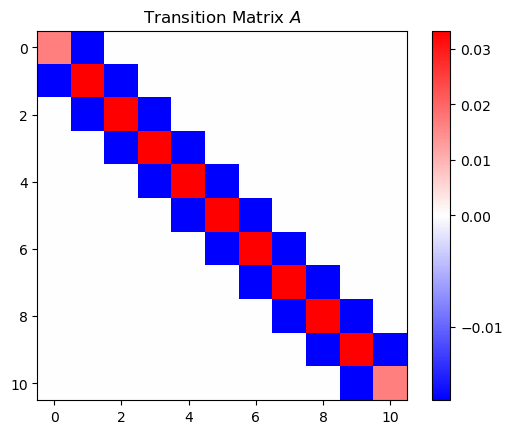

In [7]:
A = emd_model.get_transition_matrix()

# Use a diverging colormap
## https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging
cmap = matplotlib.cm.bwr

# Center the colormap on 0
## https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
divnorm = matplotlib.colors.TwoSlopeNorm(vcenter=0) #, vmin=-.01, vmax=.01)

plt.imshow(A, cmap=cmap, norm=divnorm)

plt.title("Transition Matrix $A$")
plt.colorbar()
A

## Eigenvectors, Eigenvalues, and Eigenmodes

EIGENVALUES
 0     1     2     3     4     5     6     7     8     9     10     
[0.    0.001 0.005 0.011 0.019 0.029 0.038 0.047 0.055 0.061 0.065]

EIGENVECTORS
   0    1    2    3    4    5    6    7    8    9    10    
[[ 1.   1.4  1.4 -1.3 -1.2 -1.1 -0.9 -0.8 -0.6  0.4  0.2]
 [ 1.   1.3  0.9 -0.4  0.2  0.8  1.2  1.4  1.4 -1.1 -0.6]
 [ 1.   1.1  0.2  0.8  1.4  1.3  0.6 -0.4 -1.2  1.4  0.9]
 [ 1.   0.8 -0.6  1.4  0.9 -0.4 -1.4 -1.1  0.2 -1.3 -1.2]
 [ 1.   0.4 -1.2  1.1 -0.6 -1.4 -0.2  1.3  0.9  0.8  1.4]
 [ 1.  -0.  -1.4 -0.  -1.4  0.   1.4  0.  -1.4 -0.  -1.4]
 [ 1.  -0.4 -1.2 -1.1 -0.6  1.4 -0.2 -1.3  0.9 -0.8  1.4]
 [ 1.  -0.8 -0.6 -1.4  0.9  0.4 -1.4  1.1  0.2  1.3 -1.2]
 [ 1.  -1.1  0.2 -0.8  1.4 -1.3  0.6  0.4 -1.2 -1.4  0.9]
 [ 1.  -1.3  0.9  0.4  0.2 -0.8  1.2 -1.4  1.4  1.1 -0.6]
 [ 1.  -1.4  1.4  1.3 -1.2  1.1 -0.9  0.8 -0.6 -0.4  0.2]]

EIGENMODES (e^(-eigenvalue * t))


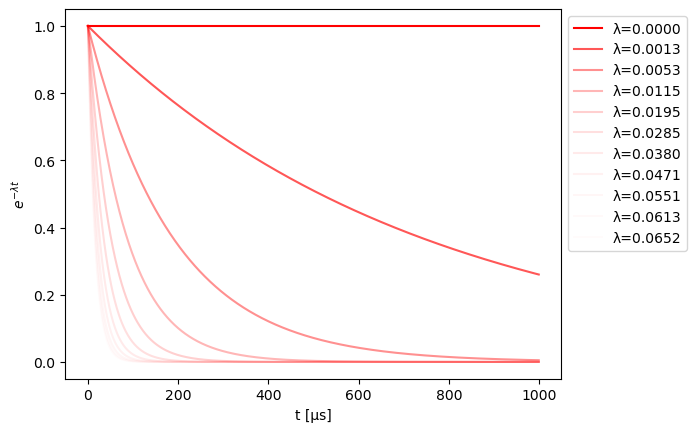

EIGENVECTORS (over space)


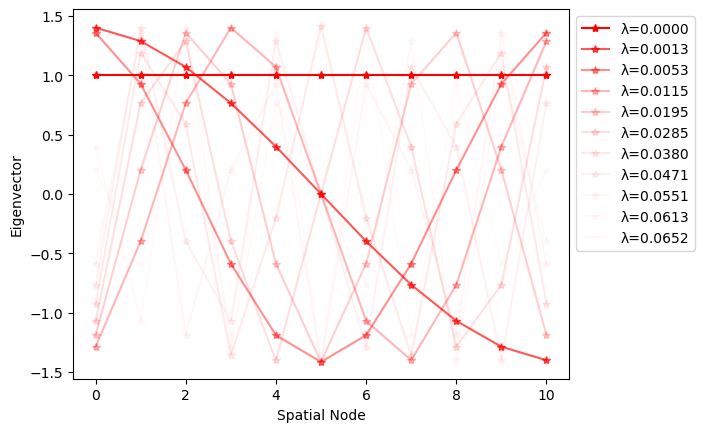

In [8]:
eigenvalues, eigenvectors, eval_sort_index = emd_model.get_eigenvalues_and_vectors(
    print_output=True, 
    plot_eigenmodes=True,
    plot_eigenvectors=True
)

## Eigenmode Impulse Injection Initial Conditions

(Copy/pasting from [stochastic-eme-soln.tex](https://www.overleaf.com/project/60ae85bacdfc625489517928))

If the simulation is an impulse of $N$ particles at node $x$, then the number of particles at each spatial node is zero, except for the location of the impulse injection 

### PARTICLE COUNTS

\begin{equation}
\begin{split}
    %m_{\pm k} = \frac{1}{2} \left(1 \pm \frac{\sum_i n_i \text{v}_{i k}}{\sqrt{N\sum_i n_i (\text{v}_{i k})^2}} \right) \\ % MER: Normalized version
    m_{\pm k} = \frac{1}{2} \left(\sqrt{N\sum_i n_i (\text{v}_{i k})^2} \pm \sum_i n_i \text{v}_{i k} \right) \\
    = \frac{1}{2} \left(\sqrt{N n_x (\text{v}_{x k})^2} \pm n_x \text{v}_{x k} \right) \\ 
    = \frac{1}{2} \left(\sqrt{N^2 (\text{v}_{x k})^2} \pm N \text{v}_{x k} \right)
\end{split}
\end{equation}

EIGENMODE INITIAL CONDITIONS
POSITIVE
[50.          0.          0.          0.          0.          0.
 70.71067812  0.          0.          0.          0.        ]
NEGATIVE
[ 0.          0.         70.71067812  0.         70.71067812 -0.
  0.          0.         70.71067812  0.         70.71067812]



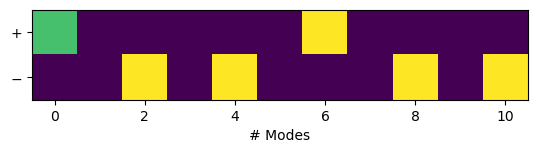

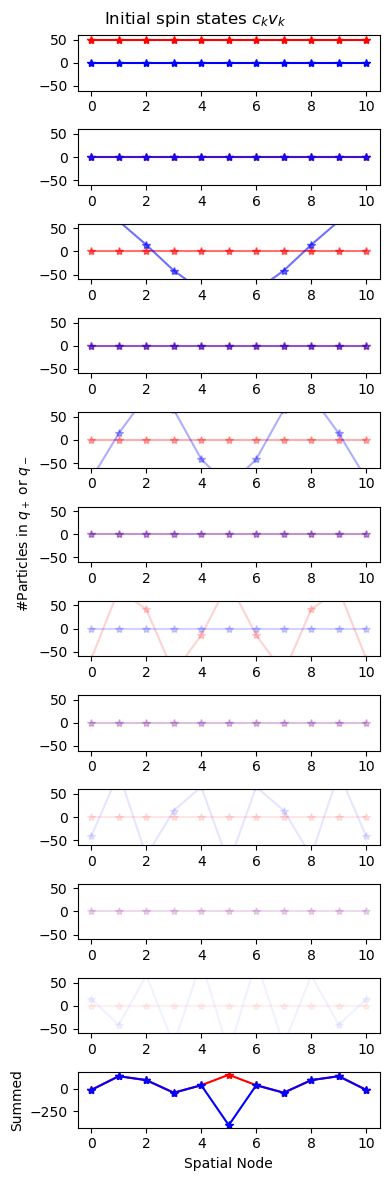

In [9]:
# Find initial values for the number of particles in each eigenmode
# For n_particles = 1, it should just be 1 and 0 respectively
init_n_positive_modes, init_n_negative_modes = emd_model.get_eme_init_conditions(
    print_output=True, 
    plot_output=True
)

### Transition Probability In Modal Space

Transition probability given by 

\begin{equation} 
    P(transition_{\pm k \rightarrow \mp k}) = \frac{\lambda}{2} dt 
\end{equation}

where $\lambda$ is the eigenVALUE (not eigenvector or eigenmode)

In [10]:
# initialize eigenmode Markov model transition probabilities
eigenmode_transition_probability = emd_model.get_eigenmode_transition_probability(
    print_output=True
)

EIGENMODE TRANSITION PROBABILITIES
0	1	2	3	4	5	6	7	8	9	10	
0.0e+00 6.7e-04 2.6e-03 5.7e-03 9.7e-03 1.4e-02 1.9e-02 2.4e-02 2.8e-02 3.1e-02 3.3e-02 


## Run Markov Simulation

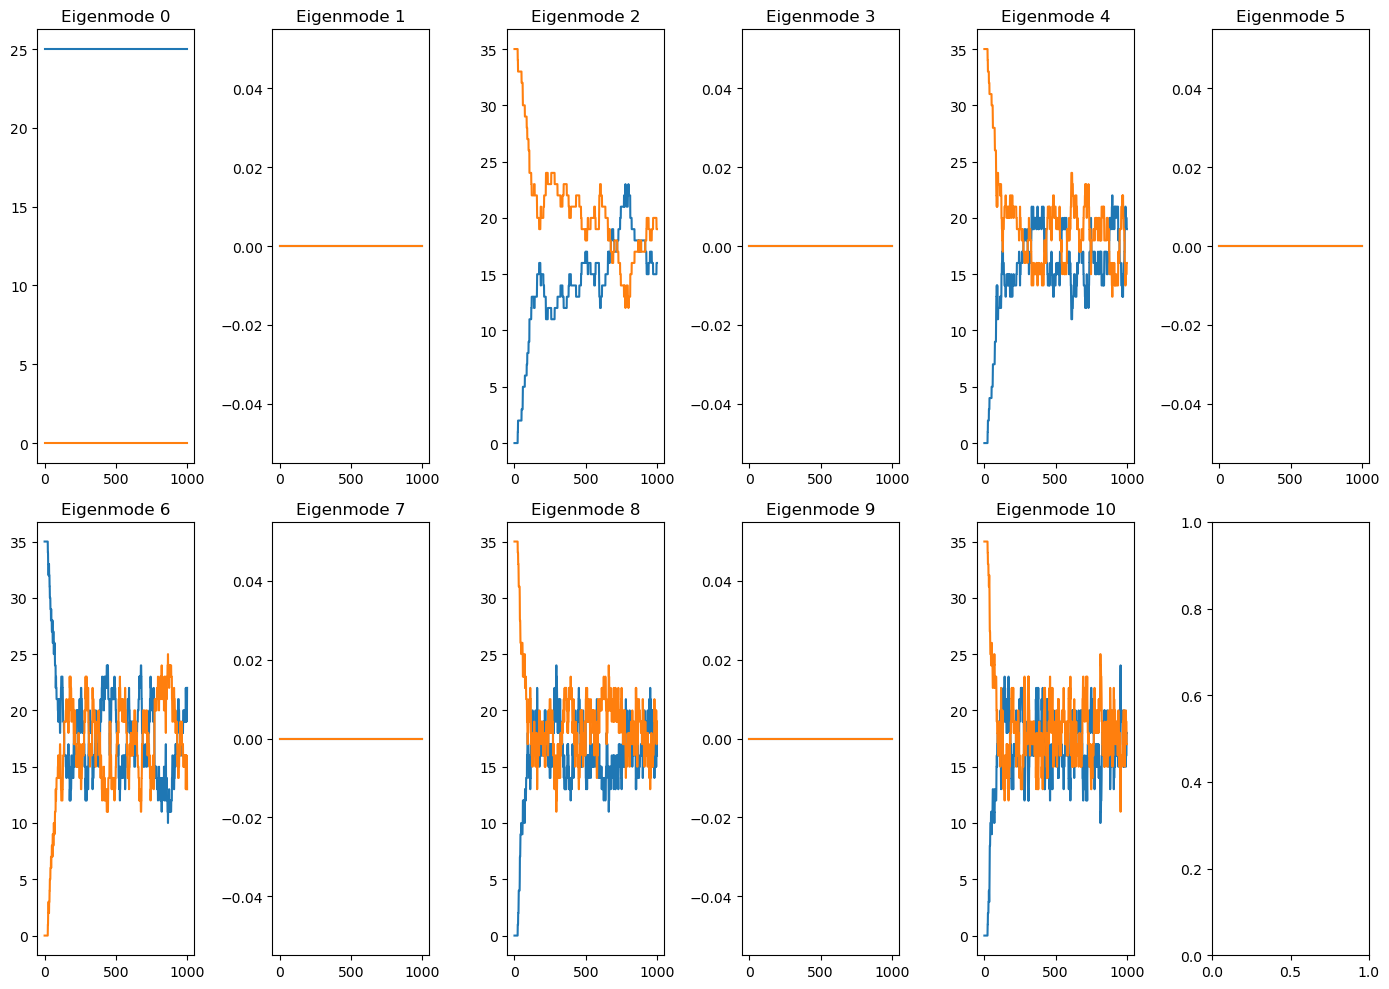

In [11]:
# %matplotlib widget 

# run Markov model
n_per_eigenmode_state = emd_model.run_simulation(
    plot_simulation=True,
    #truncation_method='reflect', # if (q+ - q-)<0, flip (reflect) the change in q+ and q-
)

## Inverse Transform

To transform the <u>number</u> of particles in each eigenmode to the <u>number</u> at each spatial location, we use the following equation:

\begin{equation} 
\begin{split}
    n_i = \sum_k \text{v}_{ik} m_k \\
    = \sum_k \text{v}_{ik} \left( m_{+k} - m_{-k} \right)
\end{split}
\end{equation}





In [12]:
# inverse transform; convert eigenmode representation to node representation
node_vals_from_modes = emd_model.convert_to_spatial_nodes(
    n_per_eigenmode_state,
    print_output=True
)

NORMALIZED COUNT PER SPATIAL NODE (FROM EIGENMODES) (N_NODES x TIME)
PRINTING SIMULATION TIME POINTS SEPARATED BY 100 TIME POINTS
0	[0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.1 0.1 0.1 0. ]
1	[0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.1]
2	[0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.  0.  0.  0.1]
3	[0.  0.  0.  0.  0.1 0.  0.  0.  0.1 0.  0.1 0.1 0.1 0. ]
4	[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1 0.1 0.  0.  0.1 0. ]
5	[0.5 0.3 0.1 0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.  0.  0.1]
6	[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1 0.1 0.  0.  0.1 0. ]
7	[0.  0.  0.  0.  0.1 0.  0.  0.  0.1 0.  0.1 0.1 0.1 0. ]
8	[0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.  0.  0.  0.1]
9	[0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.1]
10	[0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.1 0.1 0.1 0. ]



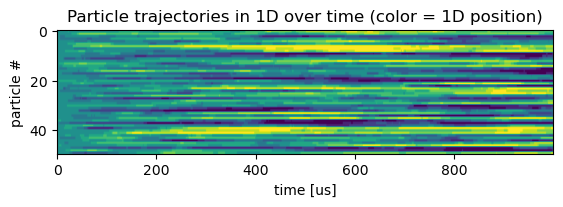

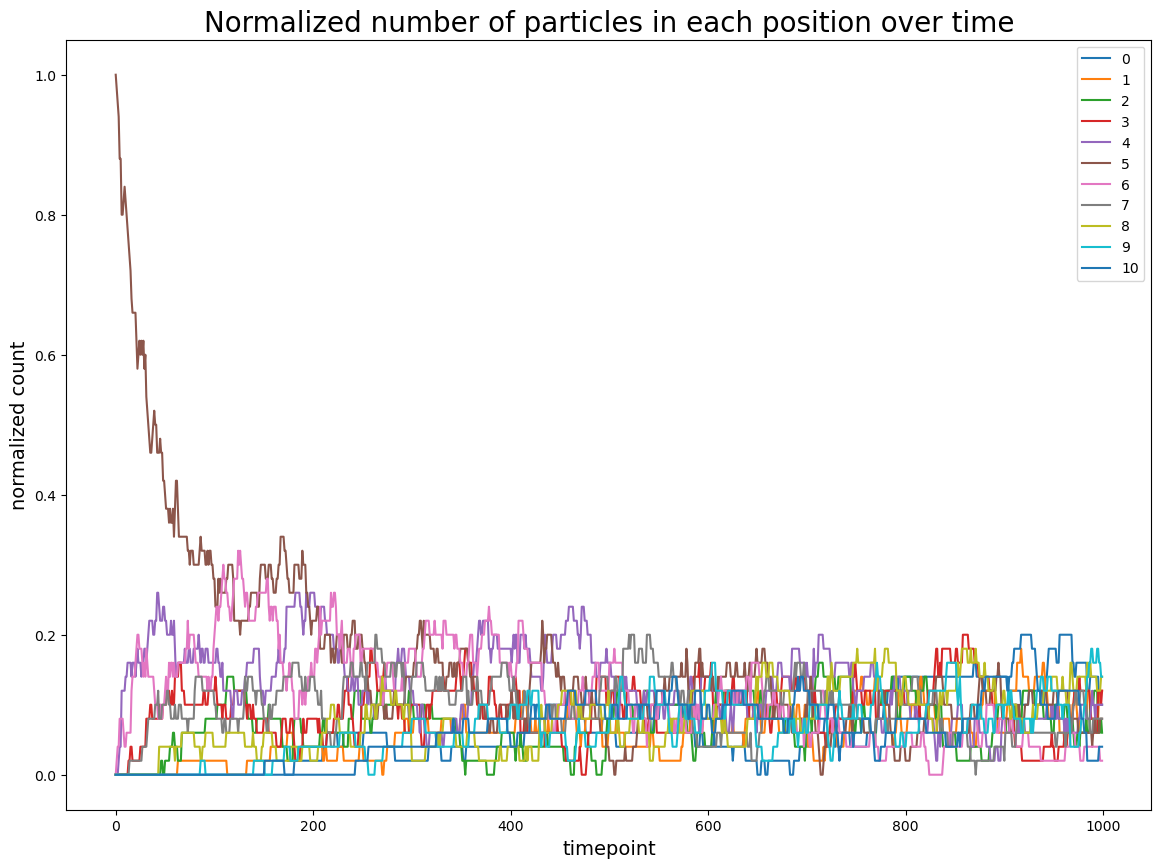

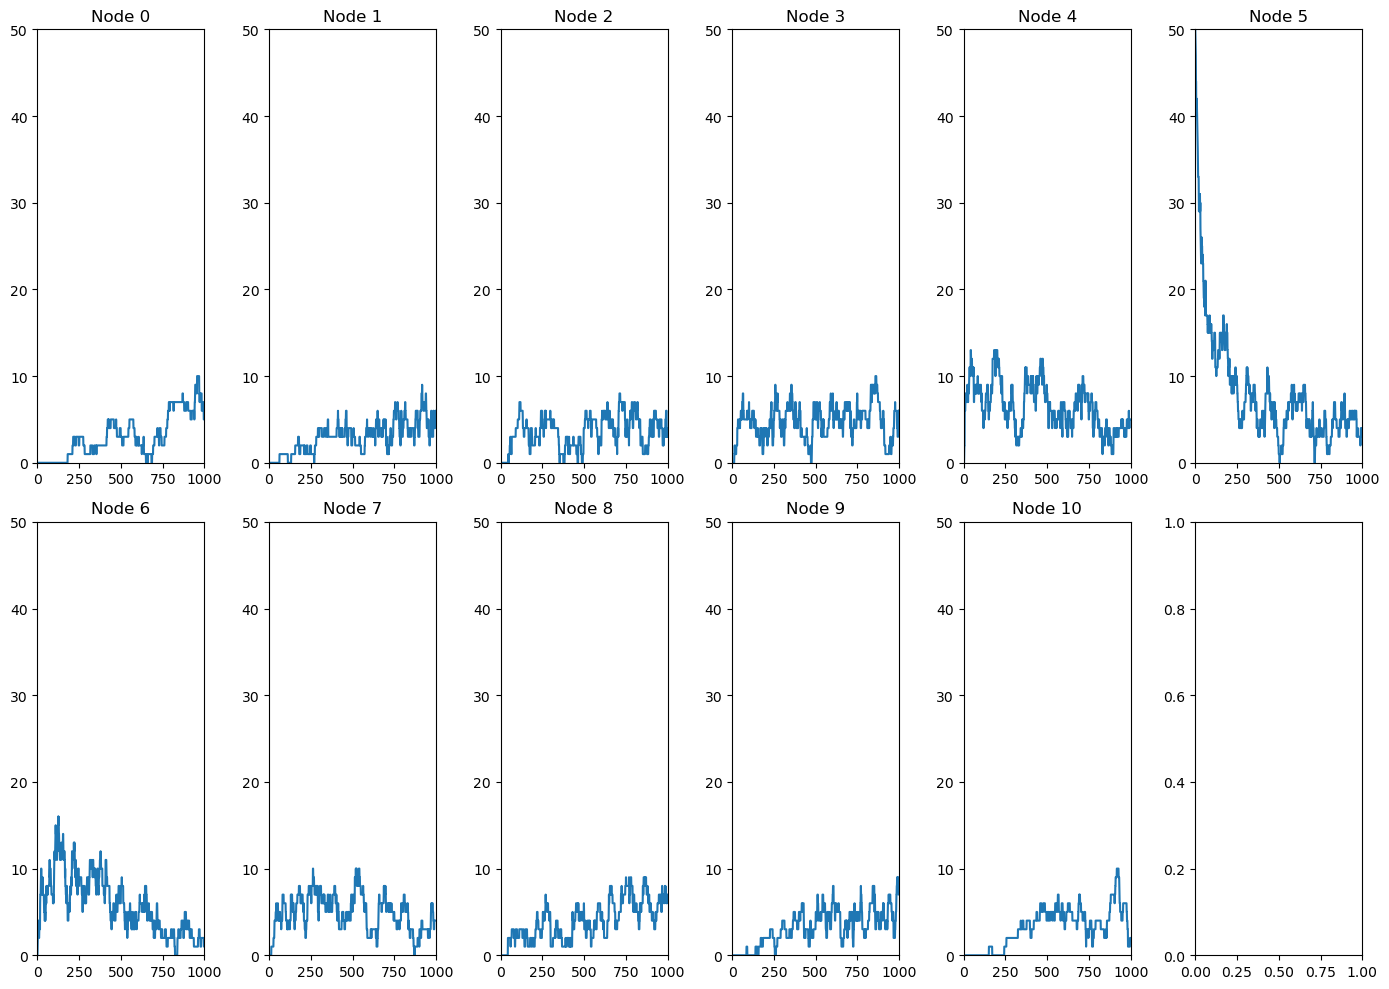

In [13]:
random_walk = rw.RandomWalk(
    n_particles=n_particles,
    n_spatial_locs=n_spatial_locs,
    n_time_pts=n_time_pts,
    particle_start_loc=particle_start_loc,
    # optional params below:
    dt=dt,
    line_length=line_length,
    diffusion_constant_D=diffusion_constant_D,
)

# Get each particle's location over time
particle_locs = random_walk.run_simulation()

# Visualize the output array
plt.imshow(particle_locs, aspect=5)
plt.ylabel('particle #')
plt.xlabel('time [us]')
plt.title('Particle trajectories in 1D over time (color = 1D position)')
plt.show()

# Reformat the output to instead collect how no. of particles at each location varies (as particles jump around)
unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk.postprocess_run(
    particle_locs=particle_locs,
    plot=True,
    plot_unnorm=True,
)

In [14]:
def graph_num_comparison(
    n1: np.ndarray, 
    n2: np.ndarray, 
    legend_vals=[], 
    title="",
    normalize=True,
    n_particles = 50, 
    particle_start_loc = 5
    ):
    
    """Graph comparing normalized number of particles at each node 
    and in each mode.

    Args:
        n1: normalized number of particles in one condition 
        (particles per time)
        n2: normalized number of particles in one condition 
        (particles per time)
    """
    import math
    # make subplots
    half_n_nodes = math.ceil(n1.shape[0] / 2)
    fig, axes = plt.subplots(half_n_nodes, 2, figsize=(14, 10))
    
    # normalize number of particles
    if normalize:
        n1 = n1 / n_particles
        n2 = n2 / n_particles

    
    for i, ax in enumerate(axes.flat):
        if i == n_spatial_locs:
            break
        ax.plot(list(range(n_time_pts)), n1[i, :])
        ax.plot(list(range(n_time_pts)), n2[i, :])
        ax.legend(legend_vals)
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_title("{} {}".format(title, i))

    fig.tight_layout()
    plt.show()
    
    print("{} PARTICLES STARTED NODE {}".format(n_particles, particle_start_loc))
    print("NORMALIZATION TURNED ON? \t", normalize)

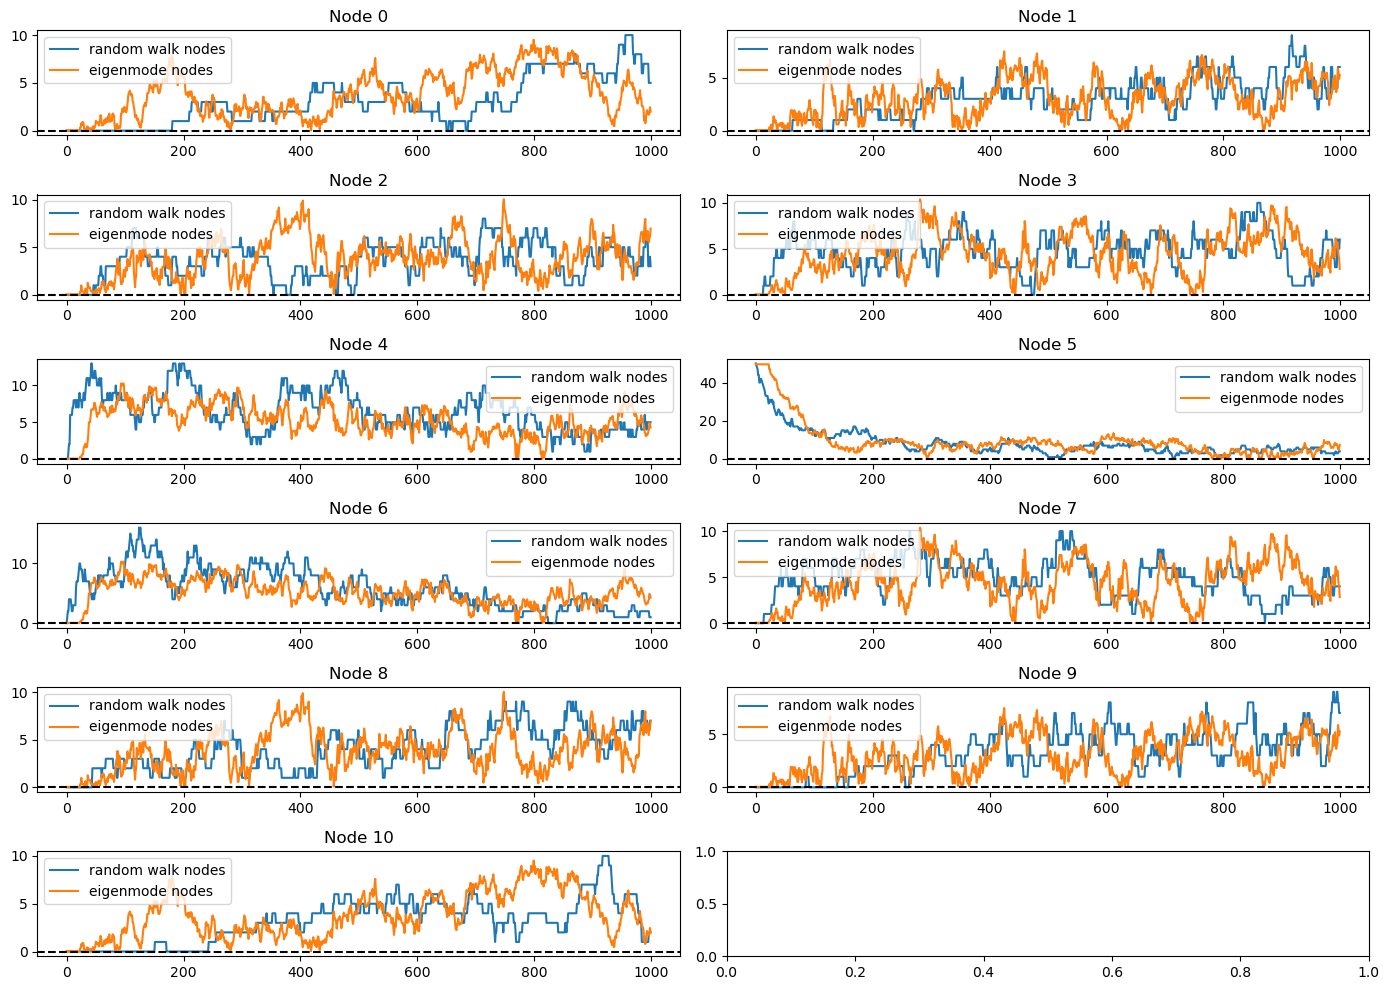

50 PARTICLES STARTED NODE 5
NORMALIZATION TURNED ON? 	 False


In [15]:
# compare with random walk simulation
graph_num_comparison(
    unnorm_n_per_loc, 
    node_vals_from_modes,
    legend_vals=["random walk nodes", "eigenmode nodes"], 
    title="Node",
    n_particles = n_particles,
    particle_start_loc = particle_start_loc,
    normalize = False,
)